In [1]:
pip install tensorflow keras numpy opencv-python matplotlib scikit-learn imutils


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25857 sha256=6728b075c032f7bc2fcd61dcc158a7b2aee266ff0ce693d6f739964563cc11b2
  Stored in directory: c:\users\deepa\appdata\local\pip\cache\wheels\5b\76\96\ad0c321506837bef578cf3008df3916c23018435a355d9f6b1
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [3]:
dataset_path = r"C:\Users\deepa\Machine Learning Project's\face_mask_detector\dataset"
categories = ["with_mask", "without_mask", "incorrect_mask"]

data = []
labels = []

img_size = 224  # Resize all images to 224x224

for category in categories:
    path = os.path.join(dataset_path, category)
    label = categories.index(category)  # Assign labels (0, 1, 2)
    
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        try:
            image = load_img(img_path, target_size=(img_size, img_size))
            image = img_to_array(image)
            image = preprocess_input(image)  # Normalize input
            data.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

# Convert to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split dataset into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [4]:
# Load MobileNetV2 as base model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")  # 3 classes: with_mask, without_mask, improper_mask
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.8046 - loss: 0.4853 - val_accuracy: 0.9614 - val_loss: 0.0823
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.9835 - loss: 0.0524 - val_accuracy: 0.9807 - val_loss: 0.0510
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.9903 - loss: 0.0385 - val_accuracy: 0.9831 - val_loss: 0.0397
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.9927 - loss: 0.0214 - val_accuracy: 0.9831 - val_loss: 0.0416
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.9980 - loss: 0.0133 - val_accuracy: 0.9783 - val_loss: 0.0416
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9831 - val_loss: 0.0429
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.9880 - val_loss: 0.0356
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step
                precision    recall  f1-score   support

     with_mask       1.00      0.98      0.99       138
  without_mask       0.98      0.98      0.98       136
incorrect_mask       0.97      0.99      0.98       141

      accuracy                           0.98       415
     macro avg       0.98      0.98      0.98       415
  weighted avg       0.98      0.98      0.98       415



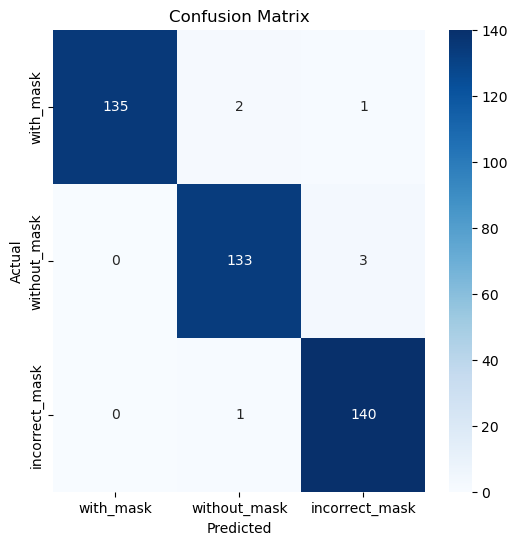

In [5]:
# Model Evaluation
y_pred = np.argmax(model.predict(X_test), axis=1)

# Classification Report
print(classification_report(y_test, y_pred, target_names=categories))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [6]:
# Load Face Detector & Trained Model
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Load trained model
model_path = "mask_detector_model.h5"
model.save(model_path)
loaded_model = tf.keras.models.load_model(model_path)

# Real-time detection using OpenCV
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, (img_size, img_size))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        pred = loaded_model.predict(face)
        label_idx = np.argmax(pred)
        label = categories[label_idx]

        # Set colors for labels
        color = (0, 255, 0) if label == "with_mask" else (0, 0, 255) if label == "without_mask" else (255, 165, 0)

        # Display result
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

    cv2.imshow("Face Mask Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━

In [ ]:
qq